# Sentiment Analysis for the IMDB Reviews Dataset

# Imported libraries and frameworks

In [1]:
from pandas import *
import tensorflow as tf
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Read and Visualized the Dataset


In [2]:
# Looked at the header and first line of the csv file:

with open("./IMDB Dataset.csv", 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First line looks like this:\n\n{csvfile.readline()}") 

Header looks like this:

review,sentiment

First line looks like this:

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far a

In [4]:
# Read CSV Columns Into List using Pandas
data = read_csv("./IMDB Dataset.csv")

In [5]:
# printing list data
print(data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [6]:
# Number of positive and negative reviews
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

C:\Users\paula\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment distribution')

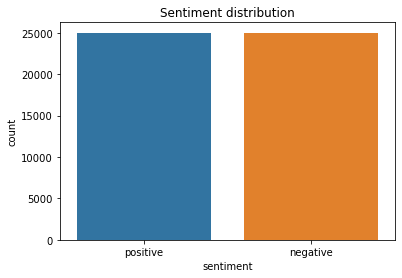

In [7]:
sns.countplot(data['sentiment'])
plt.title("Sentiment distribution")

In [8]:
# we see that there is no null value in our data.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Data preprocessing

In [9]:
# Used sklearn to encode the labels from positive/negative to 0/1 
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
# converting column data to list
sentences = data['review'].tolist()
labels = data['sentiment'].tolist()


In [11]:
print(len(sentences))

50000


# Split the Dataset

In [13]:
training_size = 45000 # 80%

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]


# Generated the vocabulary and padded sequences

In [14]:
# parametres

# the tokenizer takes the top 10000 words by volume and just encode those (the 10000 most common)
vocab_size =10000

# out of vocabulary 
oov_tok = "<OOV>"

# max number of words in each sentence
max_length = 120

# loose info from the end of each sentence
trunc_type='post'

# adds zeros at the end of each sentence
padding_type='post'

# Tokenizer API

# Initialized the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Tokenized the input sentences
tokenizer.fit_on_texts(training_sentences)

# Generated the word index dictionary where the key is the word and the value is the token for that word
word_index = tokenizer.word_index

# Generate list of token sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)

# pad_sequences API

# padded the sequences to uniform length
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays (to be able to fit the models) the pad_sequences returns numpy arrays 
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Built and Trained the Model

# Plot to visualize the accuracy and loss history after training

In [15]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Model 1: Flatten

In [17]:
# Parameters
embedding_dim = 16
dense_dim = 6
dropout_rate = 0.80

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 dropout (Dropout)           (None, 120, 16)           0         
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [18]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(training_padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
352/352 [==============================] - 3s 7ms/step - loss: 0.6500 - accuracy: 0.6002 - val_loss: 0.4639 - val_accuracy: 0.8018
Epoch 2/10
352/352 [==============================] - 2s 6ms/step - loss: 0.4197 - accuracy: 0.8065 - val_loss: 0.3544 - val_accuracy: 0.8450
Epoch 3/10
352/352 [==============================] - 2s 7ms/step - loss: 0.3610 - accuracy: 0.8396 - val_loss: 0.3387 - val_accuracy: 0.8530
Epoch 4/10
352/352 [==============================] - 2s 7ms/step - loss: 0.3350 - accuracy: 0.8542 - val_loss: 0.3384 - val_accuracy: 0.8504
Epoch 5/10
352/352 [==============================] - 2s 7ms/step - loss: 0.3185 - accuracy: 0.8639 - val_loss: 0.3331 - val_accuracy: 0.8536
Epoch 6/10
352/352 [==============================] - 2s 7ms/step - loss: 0.3064 - accuracy: 0.8708 - val_loss: 0.3357 - val_accuracy: 0.8530
Epoch 7/10
352/352 [==============================] - 2s 7ms/step - loss: 0.3007 - accuracy: 0.8741 - val_loss: 0.3339 - val_accuracy: 0.8576
Epoch 

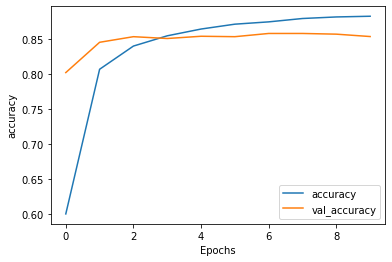

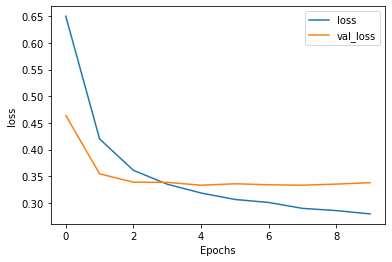

In [19]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

# LSTM

In [41]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6
dropout_rate = 0.8

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 dropout (Dropout)           (None, 120, 16)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
__________________________________________________

In [42]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
352/352 [==============================] - 60s 150ms/step - loss: 0.5509 - accuracy: 0.6943 - val_loss: 0.3736 - val_accuracy: 0.8404
Epoch 2/10
352/352 [==============================] - 48s 136ms/step - loss: 0.3843 - accuracy: 0.8304 - val_loss: 0.3481 - val_accuracy: 0.8498
Epoch 3/10
352/352 [==============================] - 50s 141ms/step - loss: 0.3516 - accuracy: 0.8496 - val_loss: 0.3485 - val_accuracy: 0.8524
Epoch 4/10
352/352 [==============================] - 49s 140ms/step - loss: 0.3315 - accuracy: 0.8593 - val_loss: 0.3306 - val_accuracy: 0.8548
Epoch 5/10
352/352 [==============================] - 48s 137ms/step - loss: 0.3204 - accuracy: 0.8649 - val_loss: 0.3385 - val_accuracy: 0.8530
Epoch 6/10
352/352 [==============================] - 49s 138ms/step - loss: 0.3131 - accuracy: 0.8680 - val_loss: 0.3293 - val_accuracy: 0.8546
Epoch 7/10
352/352 [==============================] - 48s 137ms/step - loss: 0.3051 - accuracy: 0.8716 - val_loss: 0.3319 - val_ac

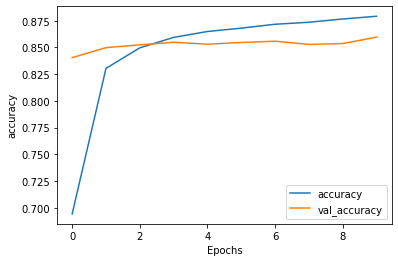

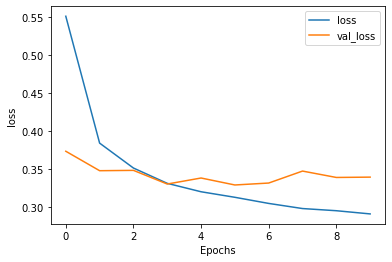

In [46]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

# LSTM 2 layers

In [47]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6
dropout_rate = 0.8

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 dropout_1 (Dropout)         (None, 120, 16)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 120, 256)         148480    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [48]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
352/352 [==============================] - 337s 920ms/step - loss: 0.5446 - accuracy: 0.7141 - val_loss: 0.3858 - val_accuracy: 0.8324
Epoch 2/10
352/352 [==============================] - 334s 948ms/step - loss: 0.3893 - accuracy: 0.8270 - val_loss: 0.3765 - val_accuracy: 0.8276
Epoch 3/10
352/352 [==============================] - 369s 1s/step - loss: 0.3507 - accuracy: 0.8463 - val_loss: 0.3442 - val_accuracy: 0.8450
Epoch 4/10
352/352 [==============================] - 380s 1s/step - loss: 0.3330 - accuracy: 0.8567 - val_loss: 0.3380 - val_accuracy: 0.8496
Epoch 5/10
352/352 [==============================] - 381s 1s/step - loss: 0.3222 - accuracy: 0.8634 - val_loss: 0.3428 - val_accuracy: 0.8534
Epoch 6/10
352/352 [==============================] - 367s 1s/step - loss: 0.3109 - accuracy: 0.8676 - val_loss: 0.3404 - val_accuracy: 0.8500
Epoch 7/10
352/352 [==============================] - 370s 1s/step - loss: 0.3068 - accuracy: 0.8698 - val_loss: 0.3327 - val_accuracy: 

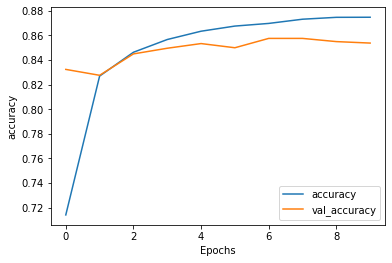

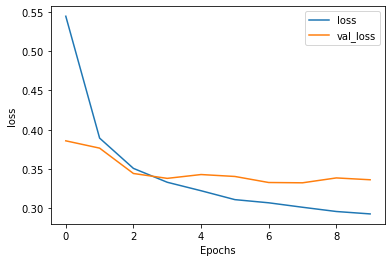

In [49]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

# GRU

In [105]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6
dropout_rate = 0.8


# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 120, 16)           160000    
                                                                 
 dropout_24 (Dropout)        (None, 120, 16)           0         
                                                                 
 bidirectional_15 (Bidirecti  (None, 64)               9600      
 onal)                                                           
                                                                 
 dense_46 (Dense)            (None, 6)                 390       
                                                                 
 dense_47 (Dense)            (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_______________________________________________

In [106]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(training_padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
352/352 [==============================] - 50s 130ms/step - loss: 0.6406 - accuracy: 0.5983 - val_loss: 0.4523 - val_accuracy: 0.7936
Epoch 2/10
352/352 [==============================] - 38s 107ms/step - loss: 0.4147 - accuracy: 0.8134 - val_loss: 0.3492 - val_accuracy: 0.8450
Epoch 3/10
352/352 [==============================] - 38s 108ms/step - loss: 0.3581 - accuracy: 0.8440 - val_loss: 0.3472 - val_accuracy: 0.8474
Epoch 4/10
352/352 [==============================] - 38s 109ms/step - loss: 0.3354 - accuracy: 0.8559 - val_loss: 0.3296 - val_accuracy: 0.8576
Epoch 5/10
352/352 [==============================] - 39s 111ms/step - loss: 0.3190 - accuracy: 0.8638 - val_loss: 0.3273 - val_accuracy: 0.8570
Epoch 6/10
352/352 [==============================] - 39s 112ms/step - loss: 0.3065 - accuracy: 0.8691 - val_loss: 0.3283 - val_accuracy: 0.8572
Epoch 7/10
352/352 [==============================] - 41s 115ms/step - loss: 0.3028 - accuracy: 0.8716 - val_loss: 0.3235 - val_ac

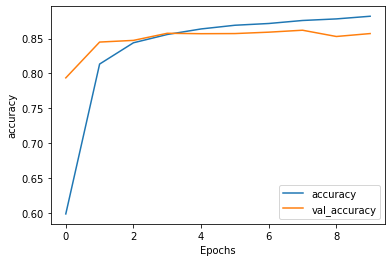

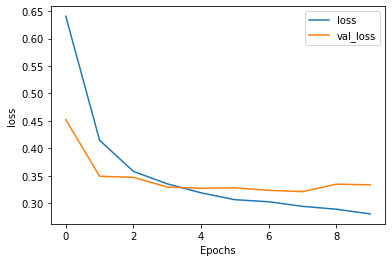

In [107]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

# Convolution

In [102]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 16
dropout_rate = 0.8

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 120, 16)           160000    
                                                                 
 dropout_23 (Dropout)        (None, 120, 16)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_5   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_44 (Dense)            (None, 16)                2064      
                                                                 
 dense_45 (Dense)            (None, 1)                 17        
                                                     

In [103]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(training_padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
352/352 [==============================] - 20s 54ms/step - loss: 0.5984 - accuracy: 0.6976 - val_loss: 0.4898 - val_accuracy: 0.8236
Epoch 2/10
352/352 [==============================] - 19s 55ms/step - loss: 0.4709 - accuracy: 0.8254 - val_loss: 0.4374 - val_accuracy: 0.8426
Epoch 3/10
352/352 [==============================] - 19s 54ms/step - loss: 0.4212 - accuracy: 0.8403 - val_loss: 0.4086 - val_accuracy: 0.8448
Epoch 4/10
352/352 [==============================] - 19s 54ms/step - loss: 0.3881 - accuracy: 0.8517 - val_loss: 0.3909 - val_accuracy: 0.8482
Epoch 5/10
352/352 [==============================] - 20s 57ms/step - loss: 0.3640 - accuracy: 0.8600 - val_loss: 0.3773 - val_accuracy: 0.8502
Epoch 6/10
352/352 [==============================] - 20s 58ms/step - loss: 0.3467 - accuracy: 0.8647 - val_loss: 0.3668 - val_accuracy: 0.8506
Epoch 7/10
352/352 [==============================] - 22s 62ms/step - loss: 0.3337 - accuracy: 0.8688 - val_loss: 0.3615 - val_accuracy:

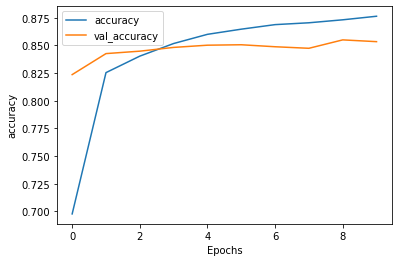

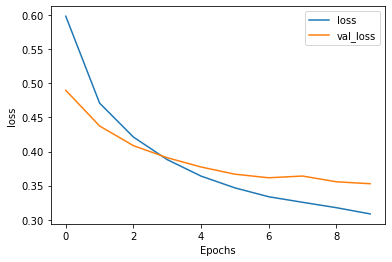

In [104]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')